<h1>Proton Therapy Optimization</h1>

## Naive modeling
The first idea that comes to mind is to make a straight forward mathematical translation of the oral problem description. That would be to set a vector of $i$ integer variables $x_{i}$, representing the number of proton fractions that should be performed to patient $i$. 

We would then symbolize our input matrix as $c_{ij}$: the benefit of offering $j$ proton fractions to patient $i$. While this is a very intuitive model it suffers from a very non linear object function. In the simplest case where we would like to optimize the sum or average BED, the object functions to be maximized would be:

\begin{equation*}
    \begin{aligned}
        \underset{x}{\text{max}}
            & \sum_{i} c_{ix_{i}}\cdot x_{i} 
    \end{aligned}     
\end{equation*}



## A better modeling idea

Instead we would prefer to go with a linear model. For that reason we could select another set of decision variables, that is a binary matrix $x_{ij}$ where a value of 1 denotes that $j$ fractions should be performed on patient $i$. Obviously we should constraint every rows sum to 1 (a patient will receive 0,1, ... **or** N fractions).

Our object function can now be expressed as elegandly as:
\begin{equation*}
    \begin{aligned}
            F(x)=  \sum_{ij} c_{ij}\cdot x_{ij} 
    \end{aligned}     
\end{equation*}


This is obviously as linear as it gets. Lets code it!

In [1]:
# GUROBI must be installed and a licence file must be discoverable in one of the default locations
from gurobipy import *
# Get some additional dependencies
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time

In [2]:
# Read the dataset into a 2d array. benefit[i,j] is the benefit patient i will get from j fractions
data = pd.read_csv('data/PayoffMatrix.txt', delim_whitespace = True, header = None)
benefit = data.values

In [3]:
class ProtonOptimizer(object):
    """
    An abstract class defining a common interface to be used by all our future models.
    Make sure you comply to the API meaning that your concrete class should:
    1) Be constructed by providing the BED values as a 2D np array and the capacity
    2) It should return its result by implementing the get_optimum() method
    """
    def __init__(self, BED, capacity = 100, model_name = 'abstract_therapy'):
        raise NotImplementedError("You cannot construct an abstract class")
    
    def get_optimum():
        """Returns a dictionary (int -> int) from patient ID to fractions"""
        return {}
    
    def pretty_print():
        """Override to print your models output in a meaningful way for debugging purposes"""
        print("The optimum is " + str(self.get_optimum()))

In [4]:
class LPOptimizer(ProtonOptimizer):
    """Concrete implementation of the ProtonOptimizer interface"""
    def __init__(self, BED, capacity = 100, model_name = 'proton_therapy'):
        self._BED = BED
        num_patients, max_fractions_per_patient = BED.shape
        self.patients = [i for i in range(num_patients)]
        self.fractions = [j for j in range(max_fractions_per_patient)]
        self.m = Model(model_name)
        
        # Set binary decision variables
        self.x = self.m.addVars(num_patients, max_fractions_per_patient, vtype = GRB.BINARY) 
        
        # Only one choice of fractions per patient is valid
        self.m.addConstrs(quicksum(self.x[i,j] for j in self.fractions) == 1 for i in self.patients)
        
        # We can only perform so many proton therapies per week
        self.m.addConstr(quicksum(
            quicksum(self.x[i,j] * self.fractions[j] for j in self.fractions) 
            for i in self.patients) <= capacity)
        self.m.update()
        
        self.optimum = {}

        
    def _solve(self, debug = False):
        # Set objective
        self.m.setObjective(quicksum(
            self.x[i,j] * self._BED[i,j] for i in self.patients for j in self.fractions),
                            GRB.MAXIMIZE)
        
        self.m.setParam('OutputFlag', debug)
        self.m.update()
        self.m.optimize()
        if self.m.status == GRB.Status.OPTIMAL:
            solution = self.m.getAttr("x", self.x)
            for i in self.patients:
                for j in self.fractions:
                    if(solution[i,j] == 1):
                        self.optimum[i] = j
                        break
        else:
            print("Infeasible model")
            
    def get_total_BED(self):
        return self.m.getObjective().getValue()
        
    def pretty_print(self):
        solution = self.get_optimum()
        for patient, fractions in solution.items():
            print(("Patient " + str(patient) + " should receive " + str(fractions) + " fractions"))
        
    def get_optimum(self):
        if not self.optimum:
            self._solve()
        return self.optimum

<h3> Dealing with expensive parameter lookup </h3>


Although the linear model developed above guarantees a global optimum, it has to take into consideration
every parameter, that is every value in the provided BED matrix. However lookups in the BED matrix are time expensive (~ 5 minutes per lookup). We would therefore like to come up with an accurate estimation of the BED matrix, using (linear) interpolation.

Below we see a prototype implementation. The number of actual points observed can be tuned, introducing a tradeoff between accuracy and time spent.

In [5]:
class LinearBEDPredictor(object):
    """
    A base implementation of BED matrix estimation. Given the real BED matrix and 
    a time cost per access, the predictor can output an estimation of the BED matrix along 
    with the time needed to produce it.
    
    EXTENSIONS: If you want to try another predictor (f.e non linear interpolation or series prediction)
    all you have to do is inherit this base and override the estimate() function. Make sure you
    obey its contract: it should return the predicted BED matrix as a 2D np.array. Everything else will 
    just work.
    """
    def __init__(self, BED):
        self._BED = BED
        self.num_patients, self.max_fractions_per_patient = BED.shape
        self.access_counter = 0
        self._accessed = set()

    def _getBED(self, i, j):
        """
        A class method simulating the actual generation of BED values.
        If the requested value has been already computed it returns without delay, else it
        delays for the time needed to compute it.
        """ 
        if (i,j) not in self._accessed:
            self.access_counter += 1
            self._accessed.add((i,j))
            # replace this by actual time cost, i.e 5*60 seconds to simulate real world application.
            time.sleep(0)

        return self._BED[i,j]

    def root_mean_square_error(self, granularity):
        """
        Computes and returns the mean squared error between the actual and the estimated BED
        matrix.
        """
        estimated = self.estimate(granularity)
        difference = estimated - self._BED
        return np.sqrt((difference ** 2).mean(axis=None))

        
    def estimate(self, granularity):
        """
        Check some points in regural intervals and linearly interpolate the rest.
        
        @param granurality: number of actual measurements to check
        @return estimate, cost: estimated BED matrix, time cost in seconds to compute it
        """
        if(granularity <= 1 or granularity > (self.max_fractions_per_patient - 1) / 2):
            print("Granularity should be between 2 and <num_columns/2>!")
            return None
  
        self.access_counter = 0
        self._accessed = set()
        
        div = (self.max_fractions_per_patient - 1) / (granularity - 1) 
        
        # Retrieve actual values with the simulated getter - This is time consuming.
        actual_indeces = [int(i*div) for i in range(granularity)] 
        
        actual_values = [self._getBED(i,j) for i in range(self.num_patients) for j in actual_indeces]
        
        estimate = np.empty(shape = (self.num_patients, self.max_fractions_per_patient)) * np.nan
        # Init with actual measurements  
        estimate[:, actual_indeces] = np.reshape(actual_values, (self.num_patients, len(actual_indeces)))
        # Interpolate the rest linearly
        estimate = pd.DataFrame(estimate).interpolate(axis = 1).values
        
        return estimate

x = LinearBEDPredictor(benefit)
# What is the estimated BED matrix?
estimated = x.estimate(granularity = 6)
# How many accesses were needed to compute that estimation?
num_accessed = x.access_counter
# What is the RMSE of this estimation?
rmse = x.root_mean_square_error(granularity = 3)

In [6]:
from itertools import chain
class BEDPredictorUpperBoundNaive(LinearBEDPredictor):
    """
    This is a class that helps to estimate upper bound of BED using a naive method that assumes
    that the all point between x[i] and x[j] will be of a value of x[j].
    """
    
    def get_interp_gap(self, accessed_inds, start, end):
        """Returns how many elements will have the same value betwen two interpolated points.
         E.g. if x=2 and x=4 are interpolated, the function return 4-2 = 2. 
        """
        if start > end:
            raise ValueError("Start index cannot be bigger than end index.")
            
        if start < 0  or len(accessed_inds) < end + 1: #if the indices are out of range
            return 1
        
        return accessed_inds[start] - accessed_inds[end]
    
    
    def _get_first_n_estimates(self, accessed_inds):
        """Computes estimates up to the last looked-up index in BED. 
        E.g. if accessed indeces [0, 8, 15], value 16 is not estimated in this step.
        @param accessed_inds: list looked-up indexes in BED
        returns: np.array of a shape of (number of patients, first n values)
        """
        # Reverse the indexes, so it is easy to insert max bounds for each value. Max bound of x[i, j] = BED[i, next access value]
        accessed_inds_rev = list(reversed(accessed_inds)) 
        
        first_n_estimates = [[self._getBED(i,j)] * self.get_interp_gap(accessed_inds_rev, ind, ind + 1) \
                             for i in range(self.num_patients) for ind, j in enumerate(accessed_inds_rev)]
        first_n_estimates = list(itertools.chain.from_iterable(first_n_estimates)) # make the list 1d                
        first_n_estimates = np.reshape(first_n_estimates, (self.num_patients, accessed_inds_rev[0] + 1))  #reshape into matrix
        first_n_estimates = np.apply_along_axis(lambda row: row[::-1], 1, first_n_estimates) # reversing order 
        return first_n_estimates
    
    def _get_last_n_estimates(self, accessed_inds):
        """Computes estimates after the last looked-up value in BED. 
        E.g. if accessed indeces [0, 8, 15], value 16 is estimated in this step.
        The computation is done using assumption of concativity; the growth of last values will \
        not exceed the growth of first_n_estimates[-1] - first_n_estimates[-2].     
        
        @param accessed_inds: list looked-up indexes in BED
        returns: np.array of a shape of (number of patients, last n values)
        """        
        last_n_est_count = self.max_fractions_per_patient - accessed_inds[-1] - 1 # how many values to ustimate
        last_n_estimates = [self._getBED(i, accessed_inds[-1]) + (self._getBED(i, accessed_inds[-1]) - \
                        self._getBED(i, accessed_inds[-2])) * (j+1) for i in range(self.num_patients) \
                            for j in range(last_n_est_count)]        
        last_n_estimates = np.reshape(last_n_estimates, (self.num_patients, last_n_est_count)) #reshape into matrix
        return last_n_estimates
    
    def estimate(self, granularity):
        """
        Check some points in regural intervals and linearly interpolate the rest.
        
        @param granurality: number of actual measurements to check
        @return estimate, cost: estimated BED matrix, time cost in seconds to compute it
        """
        if(granularity <= 1 or granularity > (self.max_fractions_per_patient - 1) / 2):
            print("Granularity should be between 2 and <num_columns/2>!")
            return None
  
        self.access_counter = 0
        self._accessed = set()
        
        interp_step = (self.max_fractions_per_patient - 1) / (granularity - 1) #take out -1
        
        # Which indices will and will not be access in BED look-ups
        accessed_inds = [int(i*interp_step) for i in range(granularity)]         
        
        if 0 not in accessed_inds:
            raise NotImplementedError("The values to bed access in BED does not contain index 0. Estimation of BED will not work correctly.")
            
        first_n_estimates = self._get_first_n_estimates(accessed_inds)
        last_n_estimates = self._get_last_n_estimates(accessed_inds)
        
        BED_estimates = np.c_[ first_n_estimates, last_n_estimates ]  # column-concatente first and last values 
        return BED_estimates

x = BEDPredictorUpperBoundNaive(benefit)
# What is the estimated BED matrix?
estimated = x.estimate(granularity = 6)
#TODO: why first and the second patients are swapped
# How many accesses were needed to compute that estimation?
num_accessed = x.access_counter
# What is the RMSE of this estimation?
#rmse = x.root_mean_square_error(granularity = 3)


<h3> How well does our estimator work in practice </h3>

We can start by observing the root mean square error of the estimation. However what we really care about, is the difference in the solution that our model outputs, when fed with an approximation of the actual input.

Lets observe the performance:

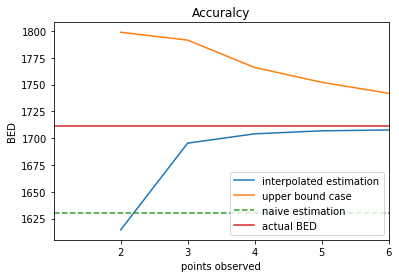

The maximum error between lower and upper bound is  {2: 11.412620439801689, 3: 5.6644529471654197, 4: 3.631526029782445, 5: 2.6509570380956182, 6: 2.0040548818860975}


In [7]:
class AccuracyHandler:
    """AccuracyHandler handles evaluating of LP model using different BED matrixes."""
    
    def __init__(self, actual_BED, gran_range):
        self.actual_BED = actual_BED
        self.gran_range = gran_range

    def get_naive_solution(self):
        "Outputs objective value of naive solution using avarage of BED values."
        naive_BED = np.ones(shape = self.actual_BED.shape) * self.actual_BED.mean()
        return self._run_lp_model(naive_BED)
        
    def get_true_solution(self):
        "Outputs objective value of optimal solution."
        return self._run_lp_model(self.actual_BED)
    
    def get_predictor_solution(self, predictor):
        """Returns a dict of objective values given granularity.
        @param predictor: Must be LinearBEDPredictor (inhereted) object.  
        """
        result = {}
        for gran in self.gran_range:
            # What is the optimum found using our estimation?
            estimated = predictor.estimate(granularity = gran)
            result[gran] = self._run_lp_model(estimated)
        return result
    
    def _sum_BED(self, BED, solution):
        """Outputs the total BED of a proposed solution"""
        total = 0
        for i,j in solution.items():
            total += BED[i,j]
        return total
    
    def _run_lp_model(self, BED, capacity = 100):
        """
        Run a LP model and get the solution given a BED matrix. Be VERY careful here,
        the ESTIMATED BED should be used to create and solve the model but the
        ACTUAL BED should be used when evaluating the quality of the solution!
        """
        optimizer = LPOptimizer(BED, capacity = capacity)
        solution = optimizer.get_optimum()
        return self._sum_BED(BED, solution)
    
    def _get_coords(self, estimates):
        """Returns x, y coords given a lits of tuples of coords."""
        coords  = sorted(estimates.items())
        x, y = zip(*coords) # unpack a list of pairs into two tuples
        return x, y

    def get_bound_error(self, lower_bounds, upper_bounds):
        """Computes percentage difference between lower and upper bounds
        @param lower_bounds, upper_bounds: is a dict like {granularity:objective function - BED}
        returns: a dict that looks like {granularity:pertance_difference}
        """
        return {i:(upper_bounds[i] - lower_bounds[i]) * 100 / lower_bounds[i] for i in self.gran_range}
        
    def draw_evaluation_plot(self):   
        """Draws a plot of granularity with a relationship to different estimators (optimal, linear internpolation..)"""
        low_bound_lin_internp = self.get_predictor_solution(LinearBEDPredictor(self.actual_BED))
        upper_bound_naive = self.get_predictor_solution(BEDPredictorUpperBoundNaive(self.actual_BED))
        avg_BED = self.get_naive_solution()
        optimal_BED = self.get_true_solution()
        
        x_li, y_li = self._get_coords(low_bound_lin_internp)
        plt.plot(x_li, y_li, label = "interpolated estimation")
                
        x_wn, y_wn = self._get_coords(upper_bound_naive)
        plt.plot(x_wn, y_wn, label = "upper bound case")

        gran_range = tuple(self.gran_range)
        # Plot naive estimation results
        plt.plot((1,) + gran_range, [avg_BED] * (len(gran_range) + 1), label = "naive estimation", linestyle = 'dashed')

        # Plot actual optimum
        plt.plot((1,) + gran_range, [optimal_BED] * (len(gran_range) + 1), label = "actual BED")

        # Edit plot
        plt.xlim(1, len(gran_range))
        plt.legend(loc='lower right')
        plt.title('Accuralcy')
        plt.xlabel('points observed')
        plt.ylabel('BED')
        plt.xticks(gran_range)
        plt.show()
        
ah = AccuracyHandler(benefit, range(2,7))
ah.draw_evaluation_plot()
lower_bound = ah.get_predictor_solution(LinearBEDPredictor(benefit))
upper_bound = ah.get_predictor_solution(BEDPredictorUpperBoundNaive(benefit))

print("The maximum error between lower and upper bound is ",ah.get_bound_error(lower_bound, upper_bound))    

** Lets visualize the effect of granularity on our solution's quality **

<h3> Conclusions </h3>


The plot above proves that linear interpolation does the trick. The solution reached through cheap estimations 
is extremely close to the actual optimum:
**(less than 1% percent objective loss using only 4 points per patient)**.


This result is extremely significant as shown by the performance of the naive estimator: A bad approximation of
the BED matrix drastically reduces our solution's quality. This benchmark also shows the motivation of using BED estimations as these can have a huge positive effect on the total BED produced.


*This performance should be acceptable in the real world, however even better estimating alternatives could be examined....*

<h3> Proving Correctness </h3>

Last but not least, our LP model seems to work correctly. However we better make sure by testing it in
simple cases where the correct answer can be computed by hand.

In [8]:
import unittest
import random

class ModelingTest(unittest.TestCase):

    def setUp(self):
        """Create a single Proton optimization model."""
        pass
        
    def mock_BED_data(self):
        BED = np.array([[1, 10, 11], [1, 2, 3], [9, 10, 11]])
        max_fractions = BED.shape[1] - 1
        return BED, max_fractions 
    
    def test_infinite_capacity(self):
        """When capacity is infinite, we expect max amount of fractions for all patients"""
        BED, max_fractions = self.mock_BED_data()
        inf_capacity = 10000
        optimizer = LPOptimizer(BED, capacity = inf_capacity)
        for patient, fractions in optimizer.get_optimum().items():
            self.assertEqual(fractions, max_fractions)

    def test_capacity_constraint(self):
        """An optimal model surely uses as many fractions as it can"""
        BED, max_fractions = self.mock_BED_data()
        num_patients = BED.shape[0]
        
        # Capacity should be unable to fulfill every patient
        capacity = random.randint(1, max_fractions * num_patients)
        
        optimizer = LPOptimizer(BED, capacity = capacity)
        solution = optimizer.get_optimum()
        fractions_used = sum(solution.values())
        self.assertEqual(fractions_used, capacity)

    def tearDown(self):
        """Delete all models."""
        pass

# Run tests
a = ModelingTest()
suite = unittest.TestLoader().loadTestsFromModule(a)
unittest.TextTestRunner().run(suite)

..
----------------------------------------------------------------------
Ran 2 tests in 0.011s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>